<img src="./images/ibm-logo.png" alt="ibm-logo" align="center" style="width: 200px;"/>

**Advanced Data Science with IBM**

<hr />

### Capstone Project


# Use Case and Data Source

**Project Description**

Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. Take this example:

<img src="./images/tweet_screenshot.png" alt="tweet_screenshot" align="center" style="width: 200px;"/>

The author explicitly uses the word “ABLAZE” but means it metaphorically. This is clear to a human right away, especially with the visual aid. But it’s less clear to a machine. The objective of this project is to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t.

**Dataset**

The dataset is open source and is available on [kaggle](https://www.kaggle.com/vstepanenko/disaster-tweets). It contains over 11,000 tweets associated with disaster keywords like “crash”, “quarantine”, and “bush fires” as well as the location and keyword itself.

The tweets were collected on Jan 14th, 2020.

Some of the topics people were tweeting:

* The eruption of Taal Volcano in Batangas, Philippines
* Coronavirus
* Bushfires in Australia
* Iran downing of the airplane flight PS752

Disclaimer: The dataset contains text that may be considered profane, vulgar, or offensive.

# Initial Data Exploration

**What files do I need?**

I used the kaggle API to fetch the file *tweets.csv*. I created an API token to get the kaggle.json file and then from my local directory I ran the command:

`kaggle datasets download -d vstepanenko/disaster-tweets`

**What should I expect the data format to be?**

Each sample in the dataset has the following information:

* The text of a tweet
* A keyword from that tweet (although this may be blank!)
* The location the tweet was sent from (may also be blank)

**What am I predicting?**

I am predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.


**Columns**

* `id` - a unique identifier for each tweet
* `text` - the text of the tweet
* `location` - the location the tweet was sent from (may be blank)
* `keyword` - a particular keyword from the tweet (may be blank)
* `target` - this denotes whether a tweet is about a real disaster (1) or not (0)

In [1]:
%%writefile disaster_tweets_nlp_data_exploration.py
#!/usr/bin/env python

import time,os,re,csv,sys,uuid,joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)
plt.style.use('seaborn')

SMALL_SIZE = 12
MEDIUM_SIZE = 14
LARGE_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)   # fontsize of the figure title

DATA_DIR = os.path.join(".","data")
IMAGE_DIR = os.path.join(".","images")

def save_fig(fig_id, tight_layout=True, image_path=IMAGE_DIR):
    """
    save the image as png file in the image directory
    """
    
    ## Check the data directory
    if not os.path.exists(image_path):
        os.makedirs(image_path)
    
    path = os.path.join(image_path, fig_id + ".png")
    print("...saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

def ingest_data(datadir=DATA_DIR, filename="tweets.csv"):
    """
    ingest tweets dataset
    """
    
    print("Ingesting Data")
    
    ## load csv file from data directory
    tweets = pd.read_csv(os.path.join(datadir,filename))
    
    ## dataframe structure
    print("...dataset of {} rows and {} columns".format(tweets.shape[0], tweets.shape[1]))
        
    ## check duplicates
    is_duplicate = tweets.duplicated(subset=["id"])
    print("...number of duplicates:", len(tweets[is_duplicate]))
    
    ## check missing data
    total = tweets.isnull().sum().sort_values(ascending=False)
    percent = (tweets.isnull().sum()/tweets.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    print("...missing values: \n {}".format(missing_data.head()))
    
    return tweets

def summarize_data(corpus, preprocessing=True):
    """
    print statements and visualizations to summarize the corpus
    """
    
    print("Summarize data")
    
    # get the documents size
    df_doc_size = pd.Series([len(str(doc).split(" ")) for doc in corpus])
    
    # get the tokens in the corpus
    df_tokens = pd.Series([token for doc in corpus for token in str(doc).split(" ")])
    
    print("---------------------------")
    print("num docs", len(corpus))
    print("median tokens", df_doc_size.median())
    print("num tokens", len(df_tokens))
    print("unique tokens", len(df_tokens.value_counts()))
    print("---------------------------")
    
    # make plots
    fig = plt.figure(figsize=(14,6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    sns.distplot(df_doc_size, ax=ax1)
    ax1.set_title("Document Sizes")
    
    sns.distplot(df_tokens.value_counts().values, ax=ax2)
    ax2.set_title("Tokens Counts")
    
    if preprocessing:
        save_fig("summarize_data_preprocessing")
    else:
        save_fig("summarize_data_postprocessing")
    
if __name__ == "__main__":
    
    run_start = time.time()
    
    ## load tweets
    tweets = ingest_data()
    
    ## summarize data
    summarize_data(tweets.text.values.tolist())
    
    print("METADATA")
    m, s = divmod(time.time()-run_start,60)
    h, m = divmod(m, 60)
    print("...run time:", "%d:%02d:%02d"%(h, m, s))
    
    print("done")


Overwriting disaster_tweets_nlp_data_exploration.py


Ingesting data
...dataset of 11370 rows and 5 columns
...number of duplicates: 0
...missing values: 
           Total   Percent
location   3418  0.300616
target        0  0.000000
text          0  0.000000
keyword       0  0.000000
id            0  0.000000
Summarize data
---------------------------
num docs 11370
median tokens 18.0
num tokens 195179
unique tokens 45250
---------------------------
...saving figure summarize_data_preprocessing
METADATA
...run time: 0:00:00
done


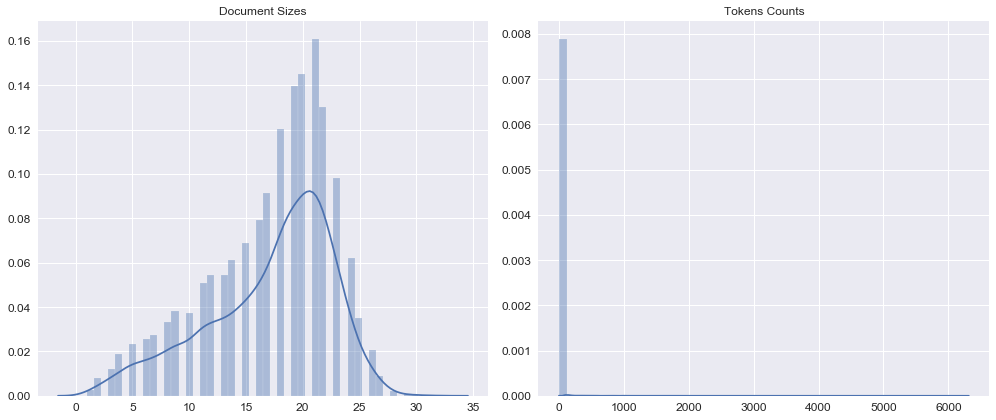

In [2]:
%run disaster_tweets_nlp_data_exploration.py

### Findings from the Initial Data Exploration

Here are some findings from the initial data exploration:

* The dataset consists of 11370 rows and 5 columns
* There aren't any duplicate records in the dataset
* There are 3418 or 30% missing values in the column `location`
* The size of the tweets varies, and the mediam size is 18 tokens
* There are 195179 total tokens
* The unique tokens in the tweets corpus are 45250

# Extract Transform Load (ETL)

Process the data. There are many options to consider when you process the tokens from a corpus of text. These are some of the questions you might want to ask?

* Which stop words do I include?
* Which stemmer/lemmatizer is best?
* Which n-grams do I include?
* Do I filter based on frequency min an max?

There are many ways to process tokens (words, dates, emojis etc). NLTK is often used to pre-process text data before the tokens are vectorized. Generally, the tokens are modified via stemming or lemmatization.

In [3]:
%%writefile disaster_tweets_nlp_etl.py
#!/usr/bin/env python

import time,os,re,csv,sys,uuid,joblib
import numpy as np
import pandas as pd
from collections import Counter
import nltk
#nltk.download("all")
from nltk.stem import WordNetLemmatizer
from string import punctuation, printable
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split

## imports from process model scripts
from disaster_tweets_nlp_data_exploration import ingest_data, summarize_data
from disaster_tweets_nlp_data_exploration import DATA_DIR

STOPLIST = ENGLISH_STOP_WORDS
STOPLIST = set(list(STOPLIST) + ["foo"])
SAVED_CORPUS = 'processed-corpus.npz'

def lemmatize_document(doc, stop_words=None):
    """
    Use the WordNetLemmatizer from nltk package
    """
    
    # create an instant of WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    
    if not stop_words:
        stop_words = set([])
    
    # ensure working with string
    doc = str(doc)
    
    # First remove punctuation from string
    if sys.version_info.major == 3:
        PUNCT_DICT = {ord(punc): None for punc in punctuation}
        doc = doc.translate(PUNCT_DICT)
        
    # remove unicode
    clean_doc = "".join([char for char in doc if char in printable])
    
    tokens = [lemmatizer.lemmatize(w.lower()) for w in clean_doc.split(" ") if len(w)>1]
    
    return " ".join([token for token in tokens if token not in stop_words])


def etl(filename=SAVED_CORPUS, clean=False):
    """
    load, clean, split and save the dataset
    """
    
    saved_corpus = os.path.join(DATA_DIR, filename)
    
    if (not os.path.exists(saved_corpus) or clean):
        
        ## data ingestion
        tweets = ingest_data()
    
        ## only the text and the target will be used from the dataset
        corpus = tweets.text.values
        target = tweets.target.values
        
        ## lemmatize
        print("ETL")
        time_start = time.time()
        processed_corpus = [lemmatize_document(tweet, STOPLIST) for tweet in corpus]
        
        ## split the dataset into training and validation set
        train_data, valid_data, y_train, y_valid = train_test_split(processed_corpus, target,
                                                                    test_size=0.25, stratify=target, random_state=42)
        print("---------------------------")
        print("training", sorted(Counter(y_train).items()))
        print("validation", sorted(Counter(y_valid).items()))
        print("---------------------------")
        
        args = {'train_data':train_data,"y_train":y_train,"valid_data":valid_data,"y_valid":y_valid}
        np.savez_compressed(saved_corpus,**args)
        print("process time", time.strftime('%H:%M:%S', time.gmtime(time.time()-time_start)))
        
    else:
        print("loading {} from file".format(saved_corpus))
        npz = np.load(saved_corpus)
        train_data, y_train = npz['train_data'], npz["y_train"]
        valid_data, y_valid = npz['valid_data'], npz["y_valid"]
    
    return train_data, y_train, valid_data, y_valid

if __name__ == "__main__":
    
    run_start = time.time()
    
    ## extract, transform load
    train_data, y_train, valid_data, y_valid = etl(clean=True)
    
    ## summarize data
    summarize_data(np.concatenate((train_data,valid_data),axis=0), preprocessing=False)
    
    print("METADATA")
    m, s = divmod(time.time()-run_start,60)
    h, m = divmod(m, 60)
    print("...run time:", "%d:%02d:%02d"%(h, m, s))
    
    print("done")


Overwriting disaster_tweets_nlp_etl.py


Ingesting data
...dataset of 11370 rows and 5 columns
...number of duplicates: 0
...missing values: 
           Total   Percent
location   3418  0.300616
target        0  0.000000
text          0  0.000000
keyword       0  0.000000
id            0  0.000000
etl
---------------------------
training [(0, 6949), (1, 1578)]
validation [(0, 2317), (1, 526)]
---------------------------
process time 00:00:03
Summarize data
---------------------------
num docs 11370
median tokens 10.0
num tokens 109323
unique tokens 26023
---------------------------
...saving figure summarize_data_postprocessing
METADATA
...run time: 0:00:03
done


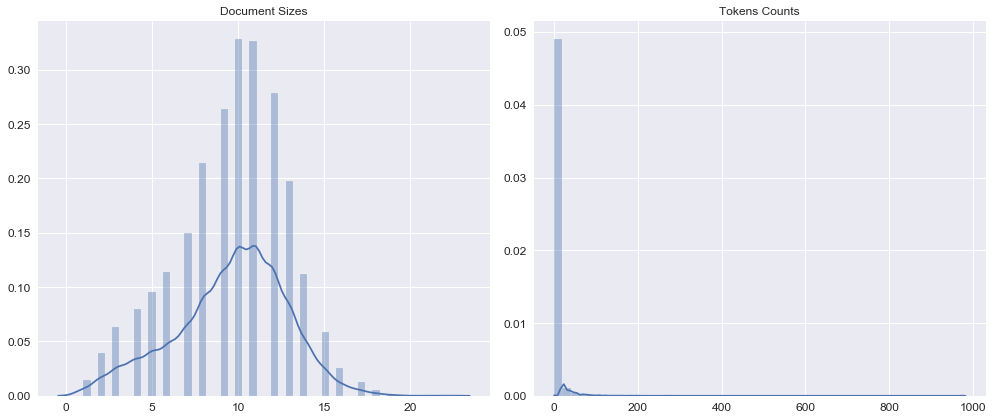

In [4]:
%run disaster_tweets_nlp_etl.py

### Findings from the ETL

Here are some findings from the ETL process:

* The dataset consists of target value and the tweets
* I drop the columns `id`, `keyword` and `location`
* After lemmatization the size of the tweets in the corpus has changes. The mediam size now is 10 tokens
* There are 109323 total tokens
* The unique tokens in the tweets corpus are 26023

# Feature Engineering

First we create a train/test split and then a transformation pipeline for feature engineering.

A bag-of-words model is a representation of text. A document or sentence is represented as numeric counts of the individual words, without considering grammar and punctuation. Even the word order is ignored unless you expand your feature matrix with n-grams.

We can calculate various measures to characterize the text. The most common type matrix derived from the bag-of-words representation term frequency (TF), which is the number of times a token appears in the text. Another useful matrix is the term frequency-inverse document frequency (tf-idf) matrix. There are variations on tf-idf and in general these derived matrices can be thought of as transforms that can be optimized in an iterative fashion.

I build a pipeline where the first step is CountVectorizer followed by TfidfTransformer.

Finally, dimensionality reduction techniques are applied to the dataset to reduce the number of features.

In [5]:
%%writefile disaster_tweets_nlp_feature_engineering.py
#!/usr/bin/env python

import time,os,re,csv,sys,uuid,joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
sns.set(style="ticks", color_codes=True)
plt.style.use('seaborn')

SMALL_SIZE = 12
MEDIUM_SIZE = 14
LARGE_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)   # fontsize of the figure title


## imports from process model scripts
from disaster_tweets_nlp_etl import etl
from disaster_tweets_nlp_data_exploration import save_fig
from disaster_tweets_nlp_data_exploration import DATA_DIR

MODEL_DIR = os.path.join(".","models")
SAVED_MODEL = "feature_engineer.joblib"

def engineer_features(valid_size=0.25, rs=42):
    """
    engineer text corpus
    """
    
    print("Engineering Features")
    
    ## etl
    train_data, y_train, valid_data, y_valid = etl()
    
    
    ## build transformation pipeline
    n_topics = 150
    lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=10, learning_method='online',
                                          learning_offset=50., random_state=rs)
    
    feature_engineer = Pipeline([('counter', CountVectorizer()),
                                 ('tfidf', TfidfTransformer()),
                                 ("lda",lda_model)])
    
    ## fit on the training set
    feature_engineer.fit(train_data)
    
    ## transform training set
    X_train = feature_engineer.transform(train_data)
    print("training data dimensions {}".format(X_train.shape))
    
    ## transform the validation set
    X_valid = feature_engineer.transform(valid_data)
    
    ## save transformation pipeline
    saved_model = os.path.join(MODEL_DIR,SAVED_MODEL)
    joblib.dump(feature_engineer, saved_model)
    
    
def create_2D_plot():
    """
    use TSNE for 2D data visualization
    """
    
    print("Create 2D plot")
    
    ## load the data
    train_data, y_train, valid_data, y_valid = etl()
    
    ## load transformation pipeline
    feature_engineer = joblib.load(os.path.join(MODEL_DIR, SAVED_MODEL))
    
    ## tsne dimensionality reduction for visualiazation
    X_count = feature_engineer.named_steps["counter"].transform(train_data)
    tsne = TSNE(n_components=2, random_state=42)
    X_2D = tsne.fit_transform(X_count)
    print(X_2D.shape)
    
    ## create plots
    plt.figure(figsize=(10,8))
    plt.plot(X_2D[:, 0][y_train==1], X_2D[:, 1][y_train==1], "ro", label="pos")
    plt.plot(X_2D[:, 0][y_train==0], X_2D[:, 1][y_train==0], "bo", label="neg")
    plt.axis('off')
    plt.legend(loc="upper left", fontsize=14)
    save_fig("tsne_visualization")
    

if __name__ == "__main__":
    
    run_start = time.time()
    
    ## feature engineering
    engineer_features()
    
    ## create 2D plot
    create_2D_plot()
    
    print("METADATA")
    m, s = divmod(time.time()-run_start,60)
    h, m = divmod(m, 60)
    print("...run time:", "%d:%02d:%02d"%(h, m, s))
    
    print("done")
    

Overwriting disaster_tweets_nlp_feature_engineering.py


loading .\data\processed-corpus.npz from file
training data dimensions (8527, 150)
loading .\data\processed-corpus.npz from file
(8527, 2)
...saving figure tsne_visualization
METADATA
...run time: 0:05:22
done


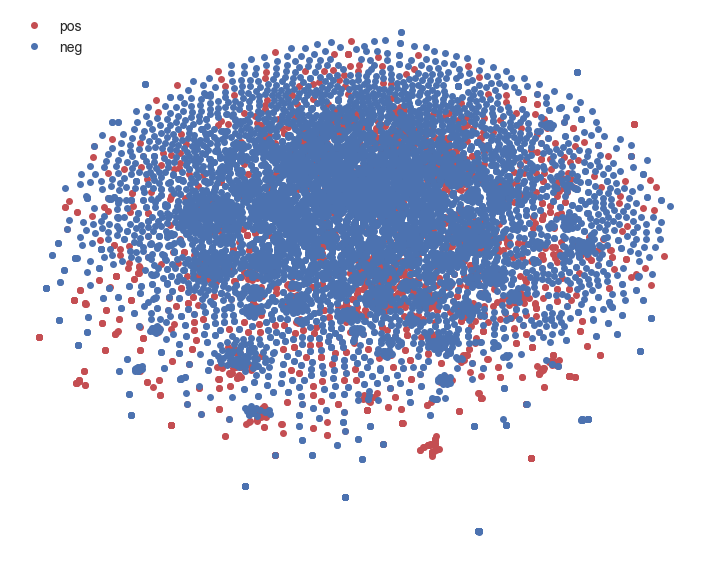

In [6]:
%run disaster_tweets_nlp_feature_engineering.py